# Triplet Loss

### Load VGG16 Model

In [1]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
import cv2 as cv
import numpy as np
import os

In [2]:
size = 64

In [3]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(size, size, 3))
gap = GlobalAveragePooling2D()(base_model.output)
model = Model(inputs=base_model.input, outputs=gap)

model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 70, 70, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 32, 32, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

### Triplet Loss Model

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [5]:
def create_triplet_loss_model(embedding_model, input_shape):
    anchor_input = layers.Input(shape=input_shape, name='anchor_input')
    positive_input = layers.Input(shape=input_shape, name='positive_input')
    negative_input = layers.Input(shape=input_shape, name='negative_input')

    # Get embeddings
    anchor_embedding = embedding_model(anchor_input)
    positive_embedding = embedding_model(positive_input)
    negative_embedding = embedding_model(negative_input)

    # Triplet loss function
    margin = 0.8
    positive_distance = tf.reduce_sum(tf.square(anchor_embedding - positive_embedding), axis=1)
    negative_distance = tf.reduce_sum(tf.square(anchor_embedding - negative_embedding), axis=1)
    loss = tf.maximum(0.0, positive_distance - negative_distance + margin)
    loss = tf.reduce_mean(loss)

    triplet_loss_model = models.Model(inputs=[anchor_input, positive_input, negative_input], outputs=loss)
    return triplet_loss_model

In [6]:
triplet_model = create_triplet_loss_model(model, input_shape=(size, size, 3))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
triplet_model.compile(optimizer=optimizer, loss='mean_squared_error')

In [7]:
triplet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 anchor_input (InputLayer)   [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 positive_input (InputLayer  [(None, 64, 64, 3)]          0         []                            
 )                                                                                                
                                                                                                  
 negative_input (InputLayer  [(None, 64, 64, 3)]          0         []                            
 )                                                                                                
                                                                                            

### Read Images and separate into anchors, positives, and negatives

In [8]:
train_folder = "../../template/BENGALI-data/train"
test_folder = "../../template/BENGALI-data/test"
validation_folder = "../../template/BENGALI-data/validation"

In [9]:
def read_images(folder_path):
    features = []
    names = []
    labels = []
    signatures = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]

    for signature in signatures:
        signature_path = os.path.join(folder_path, signature)
        images = os.listdir(signature_path)

        batch_features = []
        batch_names = []
        batch_labels = []

        for image_name in images:
            image_path = os.path.join(signature_path, image_name)
            # Read dan pre-processing gambar
            img = cv.imread(image_path)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = cv.resize(img, (size, size))
            img = np.array(preprocess_input(img))

            features.append(img)
            names.append(signature[:3])

            if signature.endswith("_forg"):
                labels.append(0)
            else:
                labels.append(1)
        
    features = np.array(features)
    names = np.array(names)
    labels = np.array(labels)
        
    return features, names, labels

In [10]:
# train_features, train_names, train_labels = read_images(train_folder)

In [11]:
train_features_triplet_path = "../../template/BENGALI-RESNET-feature/train_features_triplet.npy"
train_names_triplet_path = "../../template/BENGALI-RESNET-feature/train_names_triplet.npy"
train_labels_triplet_path = "../../template/BENGALI-RESNET-feature/train_labels_triplet.npy"

In [12]:
# np.save(train_features_triplet_path, train_features)
# np.save(train_names_triplet_path, train_names)
# np.save(train_labels_triplet_path, train_labels)

In [13]:
train_features = np.load(train_features_triplet_path)
train_names = np.load(train_names_triplet_path)
train_labels = np.load(train_labels_triplet_path)

In [14]:
print(train_features.shape)
print(train_names.shape)
print(train_labels.shape)

(3200, 64, 64, 3)
(3200,)
(3200,)


In [15]:
unique_names = set(train_names)
sorted_names = sorted(unique_names)

In [16]:
print(sorted_names)

['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100']


In [17]:
def split_positive_negative(features, names, labels, sorted_names):
    anchors = []
    positives = []
    negatives = []
    
    for name in sorted_names:
        indices = np.where(names == name)[0]
        positive_set, negative_set = [], []

        for index in indices:
            # print(labels[index])
            if labels[index] == 0:
                negative_set.append(features[index])
            else:
                positive_set.append(features[index])

        negative_set = np.array(negative_set)
        positive_set = np.array(positive_set)

        anchor = positive_set[0]
        positive_set = positive_set[1:]

        anchor_set = []
        if(len(positive_set) < len(negative_set)):
            positive_idx = np.random.choice(len(positive_set), size=len(negative_set), replace=True)
            positive = positive_set[positive_idx]
            negative = negative_set
            for _ in range(0, len(negative_set)):
                anchor_set.append(anchor)
        elif(len(positive_set) > len(negative_set)):
            negative_idx = np.random.choice(len(negative_set), size=len(positive_set), replace=True)
            negative = negative_set[negative_idx]
            positive = positive_set
            for _ in range(0, len(positive_set)):
                anchor_set.append(anchor)
        else:
            positive = positive_set
            negative = negative_set
            for _ in range(0, len(negative_set)):
                anchor_set.append(anchor)

        anchors.append(anchor_set)
        positives.append(positive)
        negatives.append(negative)

    anchors = np.concatenate(anchors)
    positives = np.concatenate(positives)
    negatives = np.concatenate(negatives)

    return anchors, positives, negatives

In [18]:
# train_anchors, train_positives, train_negatives = split_positive_negative(train_features, train_names, train_labels, sorted_names)

In [19]:
train_anchors_path = "../../template/BENGALI-RESNET-feature/train_anchors.npy"
train_positives_path = "../../template/BENGALI-RESNET-feature/train_positives.npy"
train_negatives_path = "../../template/BENGALI-RESNET-feature/train_negatives.npy"

In [20]:
# np.save(train_anchors_path, train_anchors)
# np.save(train_positives_path, train_positives)
# np.save(train_negatives_path, train_negatives)

In [21]:
train_anchors = np.load(train_anchors_path)
train_positives = np.load(train_positives_path)
train_negatives = np.load(train_negatives_path)

In [22]:
print(train_anchors.shape)
print(train_positives.shape)
print(train_negatives.shape)

(1800, 64, 64, 3)
(1800, 64, 64, 3)
(1800, 64, 64, 3)


In [23]:
history = triplet_model.fit([train_anchors, train_positives, train_negatives], np.zeros_like(train_anchors), epochs=5, batch_size=64)

Epoch 1/5

29/29 [==============================] - 199s 5s/step - loss: 89957.1250
Epoch 2/5
29/29 [==============================] - 139s 5s/step - loss: 4764.9717
Epoch 3/5
29/29 [==============================] - 137s 5s/step - loss: 346.2788
Epoch 4/5
29/29 [==============================] - 137s 5s/step - loss: 209.3957
Epoch 5/5
29/29 [==============================] - 138s 5s/step - loss: 50.3197


In [24]:
import matplotlib.pyplot as plt

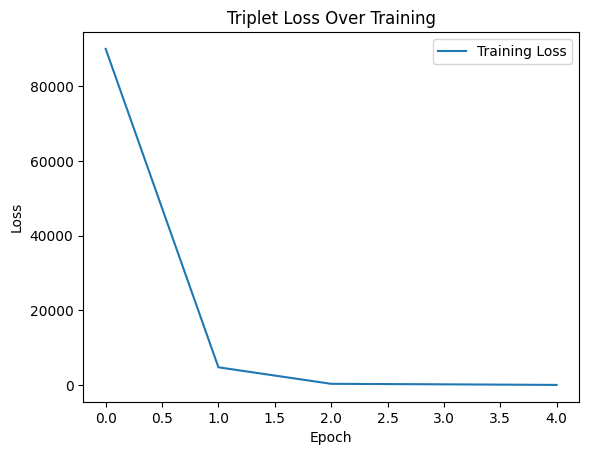

In [25]:
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Triplet Loss Over Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
model.set_weights(triplet_model.get_weights())

### Feature Extraction

In [27]:
def extract_features(folder_path, batch_size=32):
    features = []
    names = []
    labels = []
    signatures = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]

    for signature in signatures:
        signature_path = os.path.join(folder_path, signature)
        images = os.listdir(signature_path)

        batch_features = []
        batch_names = []
        batch_labels = []

        for image_name in images:
            image_path = os.path.join(signature_path, image_name)
            # Read dan pre-processing gambar
            img = cv.imread(image_path)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = cv.resize(img, (size, size))
            img = np.array(preprocess_input(img))

            batch_features.append(img)
            batch_names.append(signature[:3])

            if signature.endswith("_forg"):
                batch_labels.append(0)
            else:
                batch_labels.append(1)

            if len(batch_features) == batch_size:
                batch_features = np.array(batch_features)
                batch_features = model.predict(batch_features)
                batch_features = batch_features.reshape(len(batch_features), -1)

                features.extend(batch_features)
                names.extend(batch_names)
                labels.extend(batch_labels)

                batch_features = []
                batch_names = []
                batch_labels = []

        if batch_features:
            batch_features = np.array(batch_features)
            batch_features = model.predict(batch_features)
            batch_features = batch_features.reshape(len(batch_features), -1)

            features.extend(batch_features)
            names.extend(batch_names)
            labels.extend(batch_labels)

    return features, names, labels

In [28]:
train_features_new, _, _ = extract_features(train_folder)
test_features, _, _ = extract_features(test_folder)
validation_features, _, _ = extract_features(validation_folder)

1/1 [==============================] - 0s 166ms/step


In [29]:
print(len(train_features_new), len(train_features_new[0]))
print(len(test_features), len(test_features[0]))
print(len(validation_features), len(validation_features[0]))

3200 2048
1100 2048
1100 2048


In [30]:
print(train_features_new)

[array([0.        , 0.        , 0.        , ..., 1.1876037 , 0.        ,
       0.08779679], dtype=float32), array([0.       , 1.6166555, 1.155694 , ..., 0.8004955, 0.       ,
       0.       ], dtype=float32), array([0.12445255, 2.1625981 , 0.2885467 , ..., 0.        , 0.5247519 ,
       0.        ], dtype=float32), array([0.        , 4.28269   , 2.9216166 , ..., 0.        , 0.        ,
       0.77263075], dtype=float32), array([0.        , 0.12437843, 2.08711   , ..., 0.11909223, 0.        ,
       0.        ], dtype=float32), array([0.        , 2.7245893 , 0.32700628, ..., 0.6943578 , 0.        ,
       0.74434537], dtype=float32), array([0.        , 3.3722615 , 0.5697919 , ..., 0.7131252 , 0.03194943,
       0.        ], dtype=float32), array([0.       , 2.3975081, 5.319805 , ..., 0.       , 0.       ,
       1.4209253], dtype=float32), array([0.        , 0.        , 0.27336773, ..., 1.7293873 , 0.        ,
       0.        ], dtype=float32), array([0.       , 0.9741074, 3.0800457,

### Save and Load Features, Names, and Labels to reduce time needed

In [31]:
train_features_path =  "../feature/BENGALI-RESNET-feature/train_features_triplet_loss.npy"
test_features_path = "../feature/BENGALI-RESNET-feature/test_features_triplet_loss.npy"
validation_features_path = "../feature/BENGALI-RESNET-feature/validation_features_triplet_loss.npy"

In [32]:
np.save(train_features_path, train_features_new)
np.save(validation_features_path, validation_features)
np.save(test_features_path, test_features)